In [599]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

In [600]:
graph=nx.read_edgelist('graph.txt',nodetype=int)

In [601]:
print(type(graph))

<class 'networkx.classes.graph.Graph'>


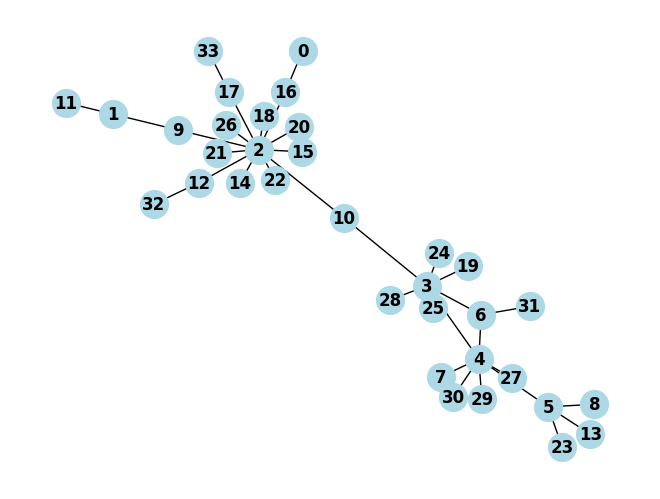

In [602]:
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=400, font_size=12, font_color='black', font_weight='bold')
plt.show()

In [603]:
def findNeighborEdges(graph,edge):
    neighborEdges = [(edge[0],neighbor) for neighbor in graph.neighbors(edge[0])] + [(edge[1],neighbor) for neighbor in graph.neighbors(edge[1])]
    return [i for i in neighborEdges if (i!=edge and i!=edge[::-1])]

# def initializePopulation(graph):

In [604]:
import random
import networkx as nx


class Individual:
    def __init__(self, sets, graph):

        self.size = sum(len(s) for s in sets)
        self.graph = graph
        self.sorted_edges = list(self.graph.edges())
        # self.sorted_edges = sorted(self.sorted_edges, key=lambda x:(x[0],x[1]))
        self.sorted_edges = [tuple(sorted(t)) for t in self.sorted_edges]
        self.sorted_edges = sorted(self.sorted_edges, key=lambda x: (x[0], x[1]))
        self.gene = {i: (None, None) for i in self.sorted_edges}
        self.sets = [{tuple(sorted(t)) for t in s} for s in sets]

        self._populate_individual(self.sets)

    def _populate_individual(self, sets):
        visited = {t: 0 for t in self.sorted_edges}

        for set in sets:
            random_set = list(set)
            random.shuffle(random_set)
            for index,cur_edge in enumerate(set):
                # if cur_edge[0]>cur_edge[1]:
                #     set[index] = (cur_edge[1], cur_edge[0])
                #     cur_edge = set[index]
                value_assigned = False
                for other_edge in random_set:
                    if visited[other_edge] or other_edge == cur_edge:
                        continue
                    if self.adjacent(cur_edge, other_edge):
                        self.gene[cur_edge] = other_edge
                        visited[other_edge] = 1
                        value_assigned=True
                        break
                if not value_assigned:
                    for other_edge in random_set:
                        if not visited[other_edge]:
                            self.gene[cur_edge] = other_edge
                            visited[other_edge] = 1
                            break

    def adjacent(self, t1, t2):
        if t1[0] == t2[0] or t1[0] == t2[1] or t1[1] == t2[0] or t1[1] == t2[1]:
            return True
        return False

    def decode(self):
        labels = {l: 0 for l in self.sorted_edges}
        c = 1
        for locus, gene_value in self.gene.items():
            gene_tuple=tuple(gene_value)
            if labels[locus] == 0 and labels[gene_tuple] == 0:
                labels[locus] = c
                labels[gene_tuple] = c
                c += 1
            elif labels[locus] == 0:
                labels[locus] = labels[gene_tuple]
            elif labels[gene_tuple] == 0:
                labels[gene_tuple] = labels[locus]

        value_to_keys = {}
        for key, value in labels.items():
            if value in value_to_keys:
                value_to_keys[value].add(key)
            else:
                value_to_keys[value] = {key}
        return list(value_to_keys.values())

    def get_gene(self, index):
        return self.gene[self.sorted_edges[index]]

    def set_gene(self, index, gene_value):
        self.gene[self.sorted_edges[index]] = gene_value

    def get_loci(self,index):
        return self.sorted_edges[index]

    def __eq__(self, other):

        for key in self.gene:
            if self.gene[key] != other.gene[key] : return False
        return True            

        # for i in range(len(self.gene)):
        #     if (self.gene[i] != other.gene[i] or self.sorted_edges[i] != other.loci[i]):
        #         return False
        # return True

    def __str__(self):
        loci_str = ', '.join(map(str, self.gene.keys()))
        gene_str = ', '.join(map(str, self.gene.values()))

        return f"Loci: [{loci_str}]\nGene: [{gene_str}]"




In [605]:
def most_frequent_label(labels, graph, v):
    neighbors_of_v = list(graph.neighbors(v))
    max_value = max(labels[key] for key in neighbors_of_v)
    max_keys = [key for key in neighbors_of_v if labels[key] == max_value]
    return random.choice(max_keys)

def node_to_edge_community(labels,graph):
    communities={}
    for edge in graph.edges():
        u, v = edge
        if labels[u] == labels[v]:
            community=labels[u]
        else : 
            community = random.choice([labels[u],labels[v]])
        if community in communities:
            communities[community].add(edge)
        else : communities[community] ={edge}
    comms = [value_set for value_set in communities.values()]
    # print(comms)
    
    return [{tuple(sorted(t)) for t in s} for s in comms]

def label_propagation(graph):
    stop = False
    labels = {node: node for node in graph.nodes()}
    while not stop:
        stop = True
        shuffled_nodes = list(graph.nodes())
        random.shuffle(shuffled_nodes)
        for v in shuffled_nodes:
            current = labels[v]
            labels[v] = most_frequent_label(labels, graph, v)

            if labels[v] != current:
                stop = False

    communities=node_to_edge_community(labels,graph)
    individual = Individual(communities,graph)
    return individual
    
    



In [606]:
#local expansion
def natural_community(graph, seed):
    nodes = list(graph.neighbors(seed)) + [seed]
    res = graph.subgraph(nodes)
    return res

def local_expansion(graph,given_nodes):
    communities = {}
    visited = {node: 0 for node in given_nodes}
    labels = {node: node for node in graph.nodes()}
    for seed in given_nodes:
        if visited[seed]:
            continue
        visited[seed] = 1
        nat_com = natural_community(graph, seed)
        for node in list(nat_com.nodes()):
            labels[node] = seed
    communities = node_to_edge_community(labels, graph)
    # for i in communities:print(i)
    
    individual = Individual(communities,graph)
    return individual

def local_expansion_random(graph):
    shuffled_nodes = list(graph.nodes())
    random.shuffle(shuffled_nodes)
    return local_expansion(graph,shuffled_nodes)

def local_expansion_by_degree(graph):
    degrees=dict(graph.degree())
    sorted_nodes = sorted(degrees, key = lambda x : degrees[x], reverse = True)
    return local_expansion(graph,sorted_nodes)

def local_expansion_by_eigenvector_centrality(graph):
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
    sorted_nodes = [node for node, centrality in sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)]
    return local_expansion(graph,sorted_nodes)


# local_expansion_by_degree(graph)
# edges=graph.edges()
# edges=sorted(edges)
# print(edges)

In [607]:
#Link Partition Density
def fitness(individual):
    communities = individual.decode();
    ans=0
    total_edge=0
    for community in communities:
        nodes=set()
        for edge in community:
            nodes.add(edge[0])
            nodes.add(edge[1])
        n = len(nodes)
        m = len(community)
        total_edge+=m
        if(n < 3):
            continue
        ans += (m*((m-(n-1))/((n-1)*(n-2))))
    ans *= (len(communities)/total_edge)
    return ans

def evaluate_population(tree):
    ans=[]
    for subtree in tree:
        for individual in subtree:
            ans.append(fitness(individual))
    return ans

In [608]:
from math import inf
def update_population(tree):
    for i in range(len(tree)):
        mx=-inf
        maxj=-1
        for j in range(len(tree[i])):
            score = fitness(tree[i][j])
            if score>mx:
                mx= score
                maxj=j
        tree[i][0],tree[i][maxj] = tree[i][maxj], tree[i][0]
    
    for i in range(12,-1,-1):
        leader = ((i+1)//3)
        supp_fitness = fitness(tree[i][0])
        lead_fitness = fitness(tree[leader][0])
        if supp_fitness > lead_fitness :
            tree[i][0],tree[leader][0] = tree[leader][0],tree[i][0]
    return tree

def update_population_offspring(tree,offspring):
    mn=inf
    mni=-1
    mnj=-1
    for i in range(len(tree)):
        for j in range(len(tree[0])):
            score=fitness(tree[i][j])
            if(score<mn):
                mni=i
                mnj=j
                mn=score
    tree[mni][mnj]=offspring
    # for subtree in tree:
    #     mn=inf
    #     maxi=-1
    #     for i in range(len(subtree)):
    #         # print(i)
    #         # print(subtree[i])
    #         fitness_value = fitness(subtree[i])
    #         if fitness_value<mn:
    #             mn=fitness_value
    #             maxi=i
    # subtree[maxi]=subtree[maxi],subtree[i]
    # tree[12][6] = offspring
    return tree


In [609]:
def initialize_population(graph):
    tree=[]
    for i in range(13):
        subtree=[]
        for j in range(7):
            # initializers=[local_expansion_random,local_expansion_by_degree,
            #                 local_expansion_by_eigenvector_centrality,label_propagation]
            initializers=[local_expansion_random,local_expansion_by_degree,
                            local_expansion_by_eigenvector_centrality]
            chosen_function = random.choice(initializers)
            subtree.append(chosen_function(graph))
        tree.append(subtree)
    tree=update_population(tree)
    return tree


In [610]:
def lost_diversity(initial, later):
    if np.std(initial)/np.std(later) < .5:
        return True
    return False


def get_best(tree):
    best = []
    mx = -inf
    for subtree in tree:
        for individual in subtree:
            score = fitness(individual)
            if score > mx:
                best = individual
                mx = score
    return best


In [611]:
def select(agent):
    return random.choice(agent)
def close_select(tree,index):
    target_index=random.choice([index*3+1,index*3+2,index*3+3])
    return random.choice(tree[target_index])

def far_select(tree,index):
    avoid=[index*3+1,index*3+2,index*3+3,index]
    target=[i for i in range(13) if (i!=0 and i not in avoid)]
    target_index=random.choice(target)
    return random.choice(tree[target_index])

def choose_parents(tree,index,eval):
    if index==0:
        parent1=random.choice(tree[0])
        parent2=random.choice(random.choice(tree[1:]))
    elif index>3:
        parent1=random.choice(tree[index])
        leader=(index-1)//3
        avoid= [leader*3+1,leader*3+2,leader*3+3]
        target = [i for i in range(4,13) if i not in avoid]
        x=random.choice(target)
        parent2=random.choice(tree[x])
    else:
        parent1=random.choice(tree[index])
        if lost_diversity(eval, evaluate_population(tree)):
            parent2 = close_select(tree,index)
        else:
            parent2 = far_select(tree,index)
    return parent1,parent2
# choose_parents(4,10)


In [612]:
def crossover(parent1, parent2, cp):
    for i in range(len(parent1.sorted_edges)):
        if random.uniform(0,1) < cp :
            gene=parent1.get_gene(i)
            parent2.set_gene(i,gene)
    return parent2

def findNeighborEdges(graph,edge):
    neighborEdges = [(edge[0],neighbor) for neighbor in graph.neighbors(edge[0])] + [(edge[1],neighbor) for neighbor in graph.neighbors(edge[1])]
    temp = [i for i in neighborEdges if (i!=edge and i!=edge[::-1])]
    return [tuple(sorted(t)) for t in temp]

def mutate(graph,individual,mp):
    for i in range(len(individual.sorted_edges)):
        if random.uniform(0,1)<mp:
            loci=individual.get_loci(i)
            neighbor=random.choice(findNeighborEdges(graph,loci))
            if neighbor[0]>neighbor[1]: neighbor = (neighbor[1],neighbor[0])
            individual.set_gene(i,neighbor)


In [613]:
def labels_to_communities(labels):
    value_sets = {}
    for key, value in labels.items():
        if value in value_sets:
            value_sets[value].add(key)
        else:
            value_sets[value] = {key}
    # print("val",value_sets)
    return list(value_sets.values())


def local_search(individual, graph):
    communities = individual.decode()
    labels = {t: 0 for t in individual.gene.keys()}
    c = 1
    for community in communities:
        for edge in community:
            labels[edge] = c
        c += 1
    best_individual = individual
    best_score = fitness(individual)
    for community in communities:
        for edge in community:
            neighbors = findNeighborEdges(graph,edge)
            # print(neighbors)
            for neighbor in neighbors:
                temp = labels[edge]
                labels[edge] = labels[neighbor]
                new_communities = labels_to_communities(labels)
                new_individual = Individual(new_communities, graph)
                score = fitness(new_individual)
                if(score > best_score):
                    best_individual = new_individual
                    best_score = score
                labels[edge]=temp
    return best_individual


In [614]:
def calc_link_density(n,m):
    return (2*m)/(n*(n-1))

def display(graph,labeled_communities,labels):
    print("Edge Communities:")
    for community,edges in labeled_communities.items():
        print(community,":",edges)
    colors = [labels[node] for node in graph.nodes()]
    pos = nx.spring_layout(graph)  # Layout the nodes
    nx.draw(graph, pos, node_color=colors, with_labels=True, cmap=plt.cm.get_cmap("viridis"))

    plt.show()

def postprocessing(individual,graph):
    communities=individual.decode()
    labels={value:set() for value in range(graph.number_of_nodes())}
    labeled_communities=dict()
    labeled_nodes=dict()

    for index,community in enumerate(communities):
        labeled_communities[index]=community
        labeled_nodes[index]=set()
        for edge in community:
            labels[edge[0]].add(index)
            labels[edge[1]].add(index)
            labeled_nodes[index].add(edge[0])
            labeled_nodes[index].add(edge[1])

    for node,community_set in labels.items():
        if(len(community_set)==1): labels[node]=community_set.pop()
        else:
            mx_label=-1
            mx_density=-inf
            for label in community_set:
                link_density =calc_link_density(len(labeled_nodes[label]),len(labeled_communities[label])) 
                if(link_density>mx_density):
                    mx_density=link_density
                    mx_label = label
            labels[node] = mx_label

    # print(communities)
    # print(labeled_nodes)
    # print(labeled_communities)
    # print(labels)
    display(graph,labeled_communities,labels)
    

In [615]:
def m_link(graph, lsp=0.1, cp=0.5, mp=0.05, generation_without_improvemnt=35):
    treePopulation = initialize_population(graph)
    eval = evaluate_population(treePopulation)
    prev_best = get_best(treePopulation)
    best = get_best(treePopulation)

    terminate = False
    generation_with_same_best = 0
    iter=0
    while not terminate:
        # print(iter)
        iter+=1
        for index, agent in enumerate(treePopulation):

            parent1, parent2=choose_parents(treePopulation, index, eval)

            offspring = crossover(parent1, parent2, cp)
            mutate(graph,offspring,mp)

            if (random.uniform(0, 1) < lsp):
                offspring=local_search(offspring,graph)

            treePopulation=update_population_offspring(treePopulation,offspring)
            treePopulation=update_population(treePopulation)

        best = get_best(treePopulation)
        if best == prev_best:
            generation_with_same_best += 1
        else:
            generation_with_same_best = 0
        if generation_with_same_best >= generation_without_improvemnt:
            terminate = True
        prev_best=best
        # if(generation_with_same_best):print(iter,fitness(best),generation_with_same_best)
        print(fitness(best))

    best_individual = get_best(treePopulation)
    best_score= fitness(best_individual)
    return best_individual,best_score
    

In [616]:
graph=nx.read_edgelist('graph.txt',nodetype=int)
ans,score=m_link(graph)
print(ans,score)

0.0
0.23284313725490194
0.23284313725490194
0.23284313725490194
0.43137254901960786
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.8823529411764706
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
0.9705882352941178
1.0147058823529411
1.0147058823529411
1.0147058823529411
1.0147058823529411
1.0147058823529411
1.0147058823529411
1.0147058823529411
1.0147058823529411
1.01

Edge Communities:
0 : {(0, 16)}
1 : {(1, 11), (1, 9)}
2 : {(2, 9)}
3 : {(2, 14), (2, 10)}
4 : {(2, 20), (2, 12)}
5 : {(2, 15)}
6 : {(2, 16), (2, 18)}
7 : {(2, 21), (2, 17)}
8 : {(2, 22)}
9 : {(2, 26)}
10 : {(4, 6), (3, 4), (3, 6)}
11 : {(3, 10)}
12 : {(3, 19)}
13 : {(3, 24), (3, 25)}
14 : {(3, 28)}
15 : {(4, 5), (5, 23)}
16 : {(4, 27), (4, 7)}
17 : {(4, 29), (4, 30)}
18 : {(5, 8)}
19 : {(5, 13)}
20 : {(6, 31)}
21 : {(12, 32)}
22 : {(17, 33)}


C:\Users\abubabu\AppData\Local\Temp\ipykernel_12844\2192401762.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(graph, pos, node_color=colors, with_labels=True, cmap=plt.cm.get_cmap("viridis"))


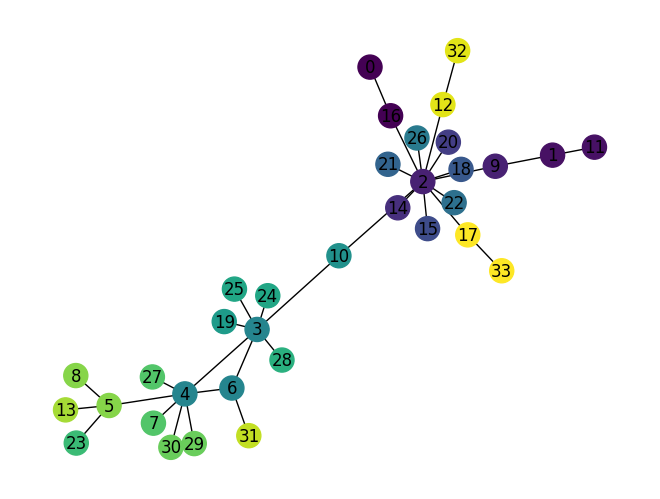

In [617]:
postprocessing(ans,graph)